<a href="https://colab.research.google.com/github/pamelamurilloa/DataMining-ISW911-ThirdProject-MachineLearning/blob/main/red_neuronal_secuencial_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto III - Machine Learning

## 0. Descripción de las variables del dataset

1. **churn:** Indica si un cliente ha abandonado el servicio o no.
2. **accountlength:** Tiempo, en días, que el cliente lleva con el servicio.
3. **internationalplan:** Indica si el cliente tiene un plan de llamadas internacionales.
4. **voicemailplan:** Indica si el cliente tiene un plan de buzón de voz.
5. **numbervmailmessages:** Número de mensajes de voz recibidos por el cliente.
6. **totaldayminutes:** Total de minutos usados por el cliente durante el día.
7. **totaldaycalls:** Total de llamadas realizadas durante el día.
8. **totaldaycharge:** Costo total de las llamadas realizadas durante el día, en dólares.
9. **totaleveminutes:** Total de minutos usados por el cliente durante la tarde.
10. **totalevecalls:** Total de llamadas realizadas durante la tarde.
11. **totalevecharge:** Costo total de las llamadas realizadas durante la tarde, en dólares.
12. **totalnightminutes:** Total de minutos usados por el cliente durante la noche.
13. **totalnightcalls:** Total de llamadas realizadas durante la noche.
14. **totalnightcharge:** Costo total de las llamadas realizadas durante la noche, en dólares.
15. **totalintlminutes:** Total de minutos usados en llamadas internacionales.
16. **totalintlcalls:** Total de llamadas internacionales realizadas.
17. **totalintlcharge:** Costo total de las llamadas internacionales, en dólares.
18. **numbercustomerservicecalls:** Número de llamadas realizadas por el cliente al servicio de atención al cliente.

## 0.1. Cargar librerías previamente

In [812]:
# Carga de las librerias
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, mean_squared_error, mean_absolute_error, r2_score, make_scorer,accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

## 1. Cargar el Conjunto de datos


### Cargar datos desde el repositorio a un dataframe

In [776]:
url ='https://raw.githubusercontent.com/pamelamurilloa/DataMining-ISW911-ThirdProject-MachineLearning/refs/heads/main/datos.csv'
df = pd.read_csv(url)

### Transformaciones previas

In [777]:
# Validar como vienen originalmente los tipos datos
print(df.dtypes)

churn                          object
accountlength                 float64
internationalplan              object
voicemailplan                  object
numbervmailmessages           float64
totaldayminutes               float64
totaldaycalls                 float64
totaldaycharge                float64
totaleveminutes               float64
totalevecalls                 float64
totalevecharge                float64
totalnightminutes             float64
totalnightcalls               float64
totalnightcharge              float64
totalintlminutes              float64
totalintlcalls                float64
totalintlcharge               float64
numbercustomerservicecalls    float64
dtype: object


In [757]:
# Convertir las variables categóricas a un formato category (equivalente a factor en R)
columns_to_convert = ['churn', 'internationalplan', 'voicemailplan']
df[columns_to_convert] = df[columns_to_convert].astype('category')

print(df.dtypes)

churn                         category
accountlength                  float64
internationalplan             category
voicemailplan                 category
numbervmailmessages            float64
totaldayminutes                float64
totaldaycalls                  float64
totaldaycharge                 float64
totaleveminutes                float64
totalevecalls                  float64
totalevecharge                 float64
totalnightminutes              float64
totalnightcalls                float64
totalnightcharge               float64
totalintlminutes               float64
totalintlcalls                 float64
totalintlcharge                float64
numbercustomerservicecalls     float64
dtype: object


## 2. División de los datos en conjuntos de entrenamiento y prueba

In [778]:
# Separar el conjunto de datos en un conjunto de entrenamiento y uno de prueba

# Esta separación esta enfocada en la predección de 'churn'

# Variables independientes:
x = df.loc[:, df.columns != 'churn']

# Variable dependiente:
y = df['churn']

# Dividir los datos en subconjuntos aleatorios de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print('Conjunto de datos separado para entrenamiento y prueba.')

Conjunto de datos separado para entrenamiento y prueba.


## 3. Justificación de la selección del modelo de Machine Learning

Las redes neuronales es un modelado poderoso para la predicción del 'Churn' debido a su capacidad para modelar relaciones complejas, de esta forma se pueden identificar múltiples interacciones complejan que afecten la elección de los clientes lo que una red neuronal puede aprender y modelar eficazmente. A pesar de que puede ser un modelo, complejo este se puede mantener un poco más simple, debido a su flexibilidad en la configuración y adaptación a los datos, esto debido a que nos permiten ajustar las números de capas y neuronas. Por lo que, su capacidad de modelado de relaciones, manejo de grandes cantidades de datos y flexibilidad podrían asegurar un modelo robusto, también son consideradas una 'caja negra', más sin embargo existen herramientas como lo es SHAP o LIME.

## 4. Entrenamiento de Modelos de Machine Learning (Red Neuronal)


### Preprocesamiento adicional

In [779]:
# Codificación de variables categóricas en las variables categóricas de entrenamiento independientes

# One-Hot Encoding, manteniendo sólo una columna '..._yes'para evitar colinealidad
x_train = pd.get_dummies(x_train, drop_first=True)
x_test = pd.get_dummies(x_test, drop_first=True)

# Asegurar que ambas divisiones tengan las mismas columnas
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

In [780]:
# Codificación de churn (variable dependiente), convirtiendolas en valores binarios

le = LabelEncoder()
y_train = le.fit_transform(y_train) # Aprendiendo que No -> 0, Yes -> 1
y_test = le.transform(y_test) # Aquí ya lo aprendió, por ende sólo transforma

# Confirmación del mapeo
print(le.classes_)

['No' 'Yes']


### Definir estructura del modelo y compilarlo

In [781]:
# Crear modelo de red neuronal secuencial
model = Sequential()

In [782]:
# Definir capas

# - Agregar la capa de entrada explícita:
model.add(Input(shape=(x_train.shape[1],)))

# - Primer capa (entrada):
model.add(Dense(units=64, activation='relu'))

# - Capa oculta
model.add(Dense(units=32, activation='relu'))

# - Regular con Dropout
model.add(Dropout(0.5))

# - Capa de salida
model.add(Dense(units=1, activation='sigmoid'))


**Explicación:**

La capa de entrada recibe los datos y empieza aprenderse los patrones, mientras que la capa oculta introduce no linealidad y procesa interacciones más complejas, ya que este es su fin. Para estos dos puntos, se utilizan 64 y 32 neuronas debido a que es común y es preferido utilizar potencias de 2 como tendencia histórica.

Para la capa de salida se utiliza `sigmoid` este devuelve una probabilidad, en la que si es mayor a 0.5 retorna 1, de lo contrario 0, lo cual nos ayuda a ilustrar la clasificación binaria, donde se posee sólo una salida por la misma razón, en la que se quiere predecir entres 'Yes' y 'No'.

### Compilar el modelo

In [783]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Entrenar modelo

In [784]:
# Detiene el entrenamiento del modelo cuando no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Ajustar el modelo
history = model.fit(
    x_train, y_train,           # Datos de entrenamiento
    validation_split=0.2,       # Usar el 20% del entrenamiento como validación
    epochs=100,                 # Número máximo de épocas
    batch_size=32,              # Tamaño del lote
    callbacks=[early_stopping], # Para finalizar si después de 5 iteraciones no mejora
    verbose=2                   # Nivel de detalle de la salida
)

Epoch 1/100
100/100 - 2s - 18ms/step - accuracy: 0.8384 - loss: 0.4658 - val_accuracy: 0.8562 - val_loss: 0.4002
Epoch 2/100
100/100 - 0s - 5ms/step - accuracy: 0.8566 - loss: 0.3955 - val_accuracy: 0.8587 - val_loss: 0.3824
Epoch 3/100
100/100 - 0s - 3ms/step - accuracy: 0.8731 - loss: 0.3783 - val_accuracy: 0.8737 - val_loss: 0.3675
Epoch 4/100
100/100 - 0s - 2ms/step - accuracy: 0.8769 - loss: 0.3578 - val_accuracy: 0.8838 - val_loss: 0.3592
Epoch 5/100
100/100 - 0s - 3ms/step - accuracy: 0.8741 - loss: 0.3431 - val_accuracy: 0.8863 - val_loss: 0.3458
Epoch 6/100
100/100 - 0s - 4ms/step - accuracy: 0.8816 - loss: 0.3371 - val_accuracy: 0.8875 - val_loss: 0.3378
Epoch 7/100
100/100 - 0s - 2ms/step - accuracy: 0.8872 - loss: 0.3179 - val_accuracy: 0.8950 - val_loss: 0.3286
Epoch 8/100
100/100 - 0s - 3ms/step - accuracy: 0.8947 - loss: 0.3112 - val_accuracy: 0.8925 - val_loss: 0.3218
Epoch 9/100
100/100 - 0s - 2ms/step - accuracy: 0.8959 - loss: 0.3018 - val_accuracy: 0.8988 - val_loss

**Resultados del entrenamiento:**

- `accuracy`: Porcentaje de predicciones correctas entrenando.

- `loss`: Valor de la función de pérdida entrenando.

- `val_accuracy`: Porcentaje de predicciones correctas en el conjunto de validación.

- `val_loss`: Valor de la función de pérdida en el conjunto de validación.

### Visualizar resultados del rendimiento del entrenamiento

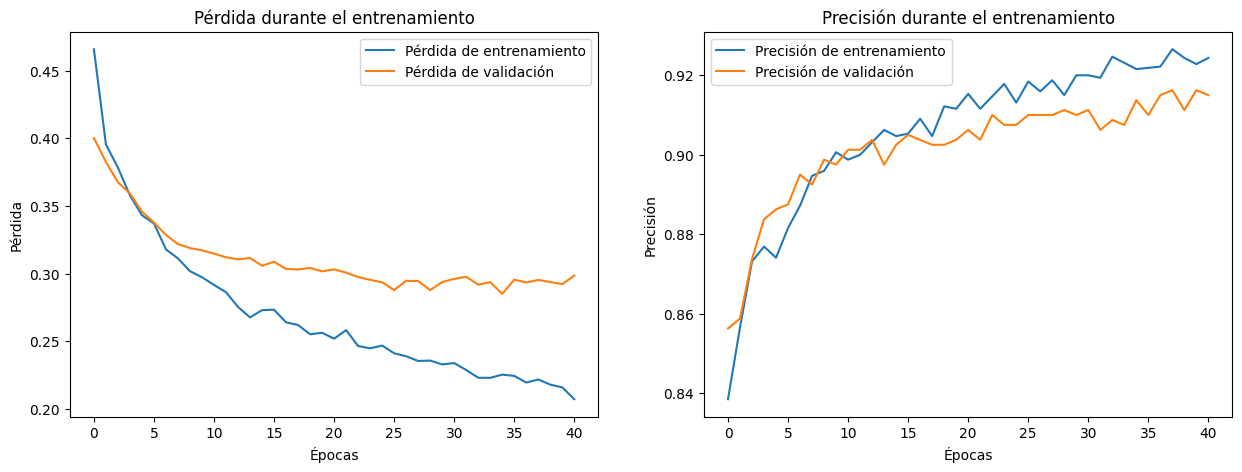

In [785]:
# Crear 2 columnas en 1 fila para los gráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pérdida
axes[0].plot(history.history['loss'], label='Pérdida de entrenamiento')
axes[0].plot(history.history['val_loss'], label='Pérdida de validación')
axes[0].legend()
axes[0].set_title('Pérdida durante el entrenamiento')
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Pérdida')

# Precisión
axes[1].plot(history.history['accuracy'], label='Precisión de entrenamiento')
axes[1].plot(history.history['val_accuracy'], label='Precisión de validación')
axes[1].legend()
axes[1].set_title('Precisión durante el entrenamiento')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Precisión')

plt.show()

## 5. Evaluación del modelo

### Evaluar modelo con los datos de prueba

In [786]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9204 - loss: 0.2513  
Test Loss: 0.2514056861400604, Test Accuracy: 0.9179999828338623


### Matriz de confusión y métricas adicionales

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


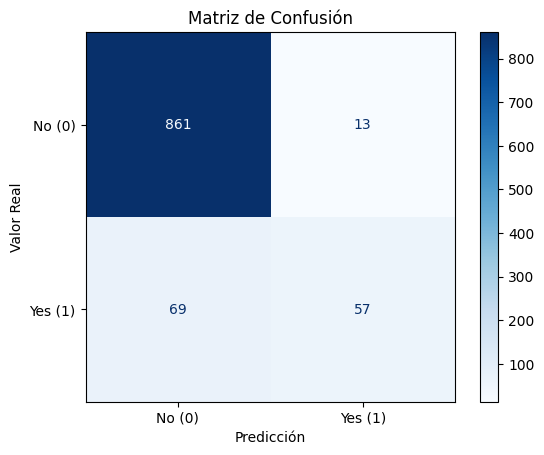

In [787]:
# Predicción elaborada
y_pred = (model.predict(x_test) > 0.5).astype("int32")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar gráficamente
def plot_confusion_matrix(cm):
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No (0)", "Yes (1)"])
  disp.plot(cmap=plt.cm.Blues, values_format='d')
  plt.xlabel("Predicción")
  plt.ylabel("Valor Real")
  plt.title("Matriz de Confusión")
  plt.show()

plot_confusion_matrix(cm)

In [788]:
# Métricas adicionales
print("\nMétricas Adicionales:")
print(classification_report(y_test, y_pred))


Métricas Adicionales:
              precision    recall  f1-score   support

           0       0.93      0.99      0.95       874
           1       0.81      0.45      0.58       126

    accuracy                           0.92      1000
   macro avg       0.87      0.72      0.77      1000
weighted avg       0.91      0.92      0.91      1000



### Calculo de Métricas (MSE y MAE)

In [789]:
# Generar las predicciones del modelo (en probabilidades)
y_pred_prob = model.predict(x_test)

# Convertir las probabilidades a 0/1:
y_pred_class = (y_pred_prob > 0.5).astype("int32")

# Calcular el Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_prob)
print("Error cuadrático medio (MSE):", mse)

# Calcular el Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_prob)
print("Error absoluto medio (MAE):", mae)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Error cuadrático medio (MSE): 0.06652052339096431
Error absoluto medio (MAE): 0.13515307457506423


### Curva ROC y AUC

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


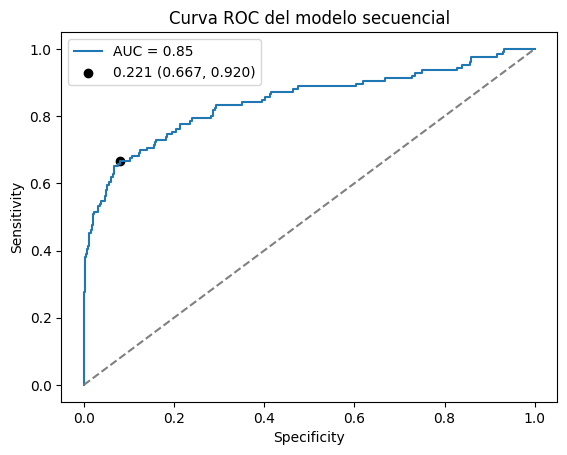

In [790]:
# Calcula fpr, tpr, y thresholds
y_pred_prob = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = auc(fpr, tpr)

# Encuentra el índice del umbral más cercano al valor deseado
index = (tpr - fpr).argmax()
threshold_selected = thresholds[index]
sensitivity = tpr[index]
specificity = 1 - fpr[index]

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.scatter(fpr[index], tpr[index], color="black", label=f"{threshold_selected:.3f} ({sensitivity:.3f}, {specificity:.3f})")
plt.xlabel("Specificity")
plt.ylabel("Sensitivity")
plt.title("Curva ROC del modelo secuencial")
plt.legend()
plt.show()

## 6. Ajustes de Parámetros

### Requilibrar Clases

In [795]:
# Calcular el peso de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict = {0: 1, 1: 1.1}

print("Pesos de las clases:", class_weights_dict)

Pesos de las clases: {0: 1, 1: 1.1}


In [796]:
# Clonar la arquitectura del modelo para pruebas
model_test = clone_model(model)

# Compilar el modelo clonado
model_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Confirmar que es un modelo independiente
print(model_test.summary())

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)                    │ (None, 64)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

None


### Reentrenar el modelo con los pesos de clase

In [797]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history_test = model_test.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    class_weight=class_weights_dict,  # Aplicar pesos de las clases
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/100
200/200 - 3s - 14ms/step - accuracy: 0.8306 - loss: 0.4938 - val_accuracy: 0.8587 - val_loss: 0.3871
Epoch 2/100
200/200 - 1s - 3ms/step - accuracy: 0.8662 - loss: 0.4131 - val_accuracy: 0.8775 - val_loss: 0.3668
Epoch 3/100
200/200 - 1s - 4ms/step - accuracy: 0.8809 - loss: 0.3803 - val_accuracy: 0.8863 - val_loss: 0.3507
Epoch 4/100
200/200 - 1s - 3ms/step - accuracy: 0.8794 - loss: 0.3550 - val_accuracy: 0.8875 - val_loss: 0.3354
Epoch 5/100
200/200 - 1s - 3ms/step - accuracy: 0.8881 - loss: 0.3406 - val_accuracy: 0.8888 - val_loss: 0.3263
Epoch 6/100
200/200 - 1s - 3ms/step - accuracy: 0.8947 - loss: 0.3295 - val_accuracy: 0.8913 - val_loss: 0.3214
Epoch 7/100
200/200 - 0s - 2ms/step - accuracy: 0.8959 - loss: 0.3231 - val_accuracy: 0.8963 - val_loss: 0.3140
Epoch 8/100
200/200 - 1s - 3ms/step - accuracy: 0.8981 - loss: 0.3150 - val_accuracy: 0.8963 - val_loss: 0.3076
Epoch 9/100
200/200 - 1s - 3ms/step - accuracy: 0.8994 - loss: 0.3043 - val_accuracy: 0.9000 - val_loss

In [798]:
model_test.evaluate(x_test, y_test, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9303 - loss: 0.2487  


[0.2407674938440323, 0.9290000200271606]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


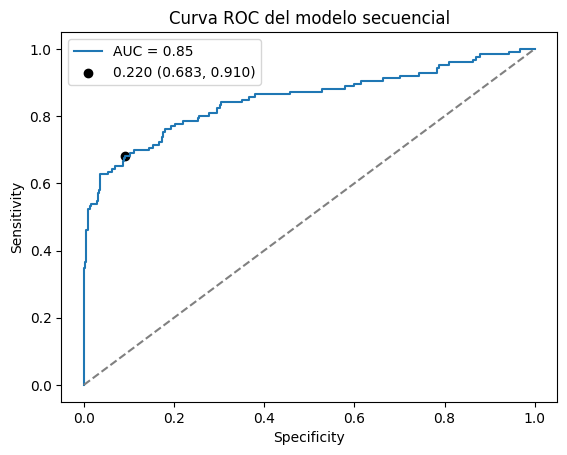

In [799]:
# Calcula fpr, tpr, y thresholds
y_pred_prob = model_test.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = auc(fpr, tpr)

# Encuentra el índice del umbral más cercano al valor deseado
index = (tpr - fpr).argmax()
threshold_selected = thresholds[index]
sensitivity = tpr[index]
specificity = 1 - fpr[index]

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.scatter(fpr[index], tpr[index], color="black", label=f"{threshold_selected:.3f} ({sensitivity:.3f}, {specificity:.3f})")
plt.xlabel("Specificity")
plt.ylabel("Sensitivity")
plt.title("Curva ROC del modelo secuencial")
plt.legend()
plt.show()

### Ajustar el Umbral

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


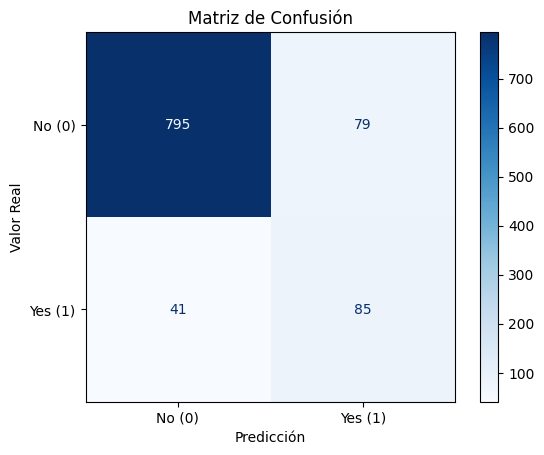

Reporte de Clasificación con umbral ajustado:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       874
           1       0.52      0.67      0.59       126

    accuracy                           0.88      1000
   macro avg       0.73      0.79      0.76      1000
weighted avg       0.90      0.88      0.89      1000



In [800]:
y_pred = model_test.predict(x_test)

# Ajustar el umbral
threshold = 0.220
y_pred_custom = (y_pred > threshold).astype("int32")

cm = confusion_matrix(y_test, y_pred_custom)
plot_confusion_matrix(cm)

# Métricas de clasificación
print("Reporte de Clasificación con umbral ajustado:")
print(classification_report(y_test, y_pred_custom))

In [807]:
# Asignar modelo resultante a nueva variable
result_model = clone_model(model)

### 7. Interpretación del modelo


### ¿Cómo hace predicciones el modelo?

### Importancia por variable

8. Predicción y uso del modelo